In [1]:
from scipy.stats import beta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

plt.style.use('ggplot')
%matplotlib inline

# Emperical Bayes on Kidney Stone Data



In [2]:
incidence = pd.read_pickle('data/kidney_incidence.pkl')
incidence.head()

,County,FIPS,Rate_per_100k,lower_95,upper_95,average_annual_count,trend,5_yr_trend,lower_95_ci_1,upper_95_ci_1
1,"Cass County, Illinois(6,10)",17017,41.1,28.0,58.5,7,rising,35.1,19.0,53.4
2,"Union County, Florida(6,10)",12125,38.7,26.6,54.9,7,stable,-16.9,-37.4,10.4
3,"Greene County, Illinois(6,10)",17061,37.5,24.7,54.9,6,stable,28.7,-19.6,106.1
4,"Benton County, Mississippi(6,10)",28009,36.6,21.2,59.1,4,stable,23.4,-1.4,54.4
5,"Hamilton County, Illinois(6,10)",17065,36.3,22.1,57.2,4,stable,2.5,-43.0,84.2


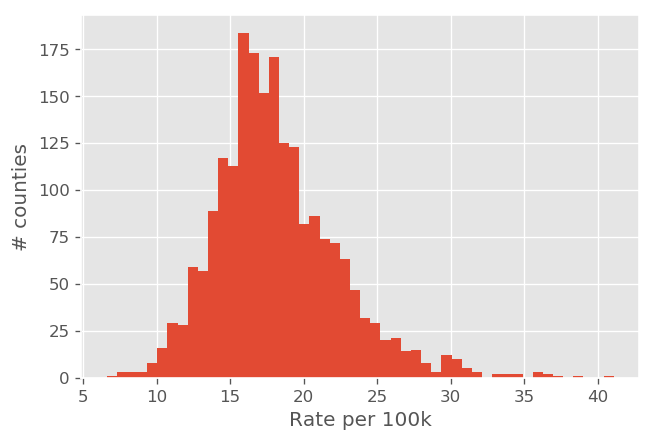

In [3]:
plt.figure(dpi=120)
plt.hist(incidence['Rate_per_100k'], bins=50);
plt.xlabel('Rate per 100k')
plt.ylabel('# counties')
plt.savefig('../../content/images/kidney/beta_distribution_nofit.png');

Had some problems pulling population data for the appropriate years. We will use rate per 100k and average annual count to infer the population. This isn't perfect because the rate is age adjusted.

In [4]:
incidence['population'] = (100000*incidence['average_annual_count']/incidence['Rate_per_100k']).astype(int)

From the graph above, it looks like the rate of kidney cancer is around 16 out of 100k people when averaged over the entire US. Put another way, the probability that a randomly chosen person develops kidney cancer is approximately 0.00016. We can estimate this more precisely using the sample mean:

In [5]:
average_rate = (incidence['population'] * incidence['Rate_per_100k']).sum()/(100000*incidence['population'].sum())
average_rate

0.00016387736201837217

## Comparison with the average

The graph below shows how the kidney cancer rates in different counties compare to the overall average kidney cancer rate. Notice that the highest and lowest incidence of cancer rates occur to the left of this graph -- i.e. where the populations are small. These are the counties that are most susceptible to fluctuations in the cancer rate. As we move to larger and larger counties, the populations move closer to the overall average. 

In an extreme example, a county with only 10 people, one person being diagonosed with kidney cancer would mean 10% of the county have kidney cancer (i.e. a rate of 10000 per 100k!), whereas a county of 10 where noone was diagnosed would have a rate of 0.

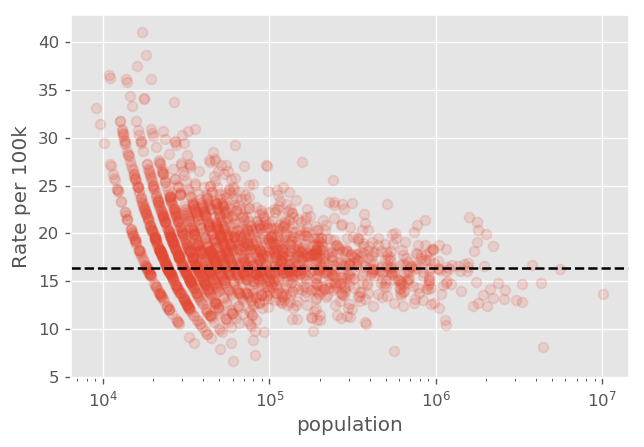

In [6]:
plt.figure(dpi=120)
plt.semilogx(incidence['population'], incidence['Rate_per_100k'], marker='o', linestyle='None', alpha=0.15)
plt.xlabel('population')
plt.ylabel('Rate per 100k')
plt.gca().axhline(average_rate*1e5, c='k', linestyle='--')
plt.savefig('../../content/images/kidney/rate_vs_pop_raw.png');

## Finding the parameters

There are a couple of different techniques for finding the parameters. One is to call the `beta.fit` method, which will find the MLE for the parameters. This is a reasonably robust technique that works well, but the details of what the fit is doing are a little obscure.

The other method is called the *method of moments*, and finds the $\alpha$ and $\beta$ that make a beta-distribution with the same mean and variance. This is simple enough to program directly.

### Method of moments

In [7]:
def method_of_moments(series):
    mean = series.mean()
    var = series.var()
    
    binom_to_actual = mean*(1-mean)/var
    alpha = mean * (binom_to_actual - 1)
    beta = (1-mean)*(binom_to_actual - 1)
    return (alpha, beta)

In [8]:
# Here is what the MoM produces:
method_of_moments(incidence['Rate_per_100k']/1e5)

(18.3604767173729, 100862.30552441531)

### Built-in MLE estimate

In [9]:
# We only want the first two parameters
alpha0, beta0, *_ = beta.fit(incidence['Rate_per_100k']/1e5, floc=0., fscale=1.)

In [10]:
print(f'The best fit parameters are alpha={alpha0}, beta={beta0}')

The best fit parameters are alpha=19.366567948095202, beta=106389.18721541032


Note that the MLE estimate produces very similar results to the method of moments. Let's plot the results using the (better) MLE estimates.

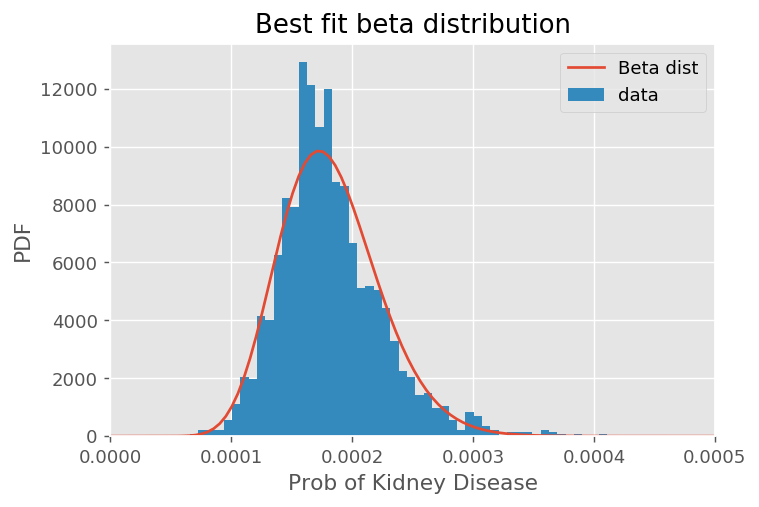

In [11]:
plt.figure(dpi=130)
X = np.linspace(0, 0.001, 200)
plt.plot(X, beta.pdf(X, a=alpha0, b=beta0, loc=0, scale=1), label='Beta dist')
plt.hist(incidence['Rate_per_100k']/100000, bins=50, normed=True, label='data')
plt.xlim(0,5e-4)
plt.title('Best fit beta distribution')
plt.legend()
plt.xlabel('Prob of Kidney Disease')
plt.ylabel('PDF');
plt.savefig('../../content/images/kidney/beta_distribution_fit.png');

In [12]:
incidence['shrinkage'] = 100000*(incidence['average_annual_count'] + alpha0)/(incidence['population'] + beta0 + alpha0)

Below we show the data after it has been "shrunk" toward $\alpha_0/(\alpha_0 + \beta_0)$, shown as the dashed line. For comparison, the average rate has been shown as a dotted line.

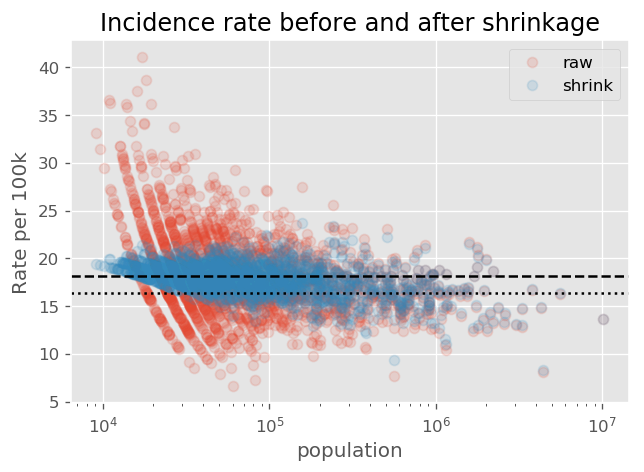

In [13]:
plt.figure(dpi=120)
plt.semilogx(incidence['population'], incidence['Rate_per_100k'], marker='o', 
             linestyle='None', alpha=0.15, label='raw')
plt.semilogx(incidence['population'], incidence['shrinkage'], marker='o', 
             linestyle='None', alpha=0.15, label='shrink')
plt.legend()
plt.title('Incidence rate before and after shrinkage')
plt.xlabel('population')
plt.ylabel('Rate per 100k')
plt.gca().axhline(average_rate*100000, c='k', linestyle=':')
plt.gca().axhline(alpha0/(alpha0 + beta0)*100000, c='k', linestyle='--');
plt.savefig('../../content/images/kidney/rate_vs_pop_shrunk.png');

In [14]:
incidence[incidence['Rate_per_100k'] == incidence['Rate_per_100k'].min()]

,County,FIPS,Rate_per_100k,lower_95,upper_95,average_annual_count,trend,5_yr_trend,lower_95_ci_1,upper_95_ci_1,population,shrinkage
2064,"Garfield County, Colorado(6,10)",8045,6.6,4.0,10.2,4,stable,0.0,-24.7,32.8,60606,13.990738


In [15]:
incidence[incidence['Rate_per_100k'] == incidence['Rate_per_100k'].max()]

,County,FIPS,Rate_per_100k,lower_95,upper_95,average_annual_count,trend,5_yr_trend,lower_95_ci_1,upper_95_ci_1,population,shrinkage
1,"Cass County, Illinois(6,10)",17017,41.1,28.0,58.5,7,rising,35.1,19.0,53.4,17031,21.359902


In [16]:
incidence['Rate_per_100k'].quantile(.23)

15.2

In [17]:
incidence[incidence['upper_95'] > incidence['Rate_per_100k'].max()]

,County,FIPS,Rate_per_100k,lower_95,upper_95,average_annual_count,trend,5_yr_trend,lower_95_ci_1,upper_95_ci_1,population,shrinkage
1,"Cass County, Illinois(6,10)",17017,41.1,28.0,58.5,7,rising,35.1,19.0,53.4,17031,21.359902
2,"Union County, Florida(6,10)",12125,38.7,26.6,54.9,7,stable,-16.9,-37.4,10.4,18087,21.178723
3,"Greene County, Illinois(6,10)",17061,37.5,24.7,54.9,6,stable,28.7,-19.6,106.1,16000,20.722872
4,"Benton County, Mississippi(6,10)",28009,36.6,21.2,59.1,4,stable,23.4,-1.4,54.4,10928,19.914142
5,"Hamilton County, Illinois(6,10)",17065,36.3,22.1,57.2,4,stable,2.5,-43.0,84.2,11019,19.898710
6,"Holmes County, Mississippi(6,10)",28051,36.2,25.1,50.6,7,stable,35.1,-15.2,115.1,19337,20.968191
7,"Dawson County, Texas(6,10)",48115,36.2,23.5,53.4,5,stable,-5.2,-37.9,44.8,13812,20.268221
8,"Powell County, Kentucky(7)",21197,35.8,22.5,54.3,5,*,NaN,NaN,NaN,13966,20.242291
9,"Edmonson County, Kentucky(7,8)",21061,34.4,22.2,51.3,5,rising,8.1,2.7,13.8,14534,20.147225
10,"Nolan County, Texas(6,10)",48353,34.2,22.8,49.5,6,stable,26.5,-25.6,115.0,17543,20.464905


In [18]:
alpha0 / (alpha0 + beta0)

0.00018200198442245913

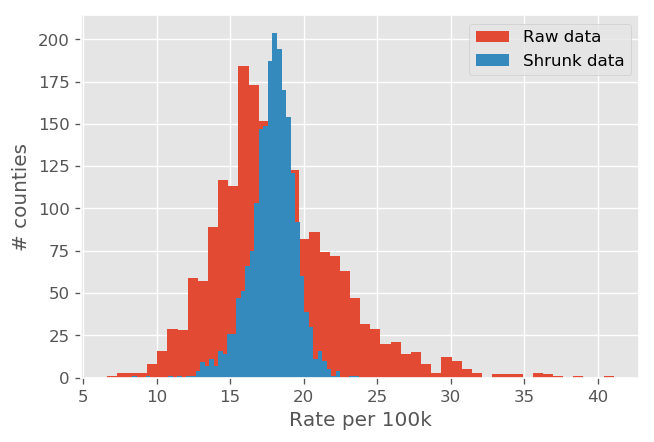

In [19]:
plt.figure(dpi=120)
plt.hist(incidence['Rate_per_100k'], bins=50, label='Raw data');
plt.hist(incidence['shrinkage'], bins=50, label='Shrunk data');
plt.xlabel('Rate per 100k')
plt.ylabel('# counties')
plt.legend()
plt.savefig('../../content/images/kidney/histograms.png');

## Mixture models

Going back to the picture of the distributions for the raw data, it looks like there might be two binomial distributions at play. Here is how we disentangle them:
1. First assign counties to two separate groups
2. Then find the alpha_0 and beta_0 for those groups
3. For each point, assign it to the group it was most likely to come from based on the alpha_0 and beta_0 for the two groups (i.e. compare PDFs). 
4. Go back to step 2 until satisfied with results

In [20]:
incidence['group'] = np.random.randint(0, 2, size=len(incidence))

In [21]:
def do_iteration(df):
    group_param = {}
    list_of_columns = []
    for gpname, grp in df.groupby('group'):
        alpha0, beta0, *_ = beta.fit(grp['Rate_per_100k']/1e5, floc=0., fscale=1.)
        group_param[gpname] = (alpha0, beta0)
        list_of_columns.append(beta.pdf(df['Rate_per_100k']/1e5, alpha0, beta0).reshape(-1, 1))
    pdfs = np.concatenate(list_of_columns, axis=1)
    
    probs = pdfs[:, 0]/pdfs.sum(axis=1)
    df.group = (np.random.random(size=len(df)) < probs).astype(int)
    return group_param

In [22]:
beta.pdf(incidence['Rate_per_100k']/1e5, 3, 3).reshape(-1, 1)

array([[5.06346526e-06],
       [4.48959304e-06],
       [4.21558653e-06],
       ...,
       [1.77842609e-07],
       [1.59846660e-07],
       [1.30662751e-07]])

In [23]:
for _ in range(200):
    gp_param = do_iteration(incidence)
gp_param

{0: (14.236232605069553, 73680.78609495956),
 1: (35.65931110114651, 207527.4906690682)}

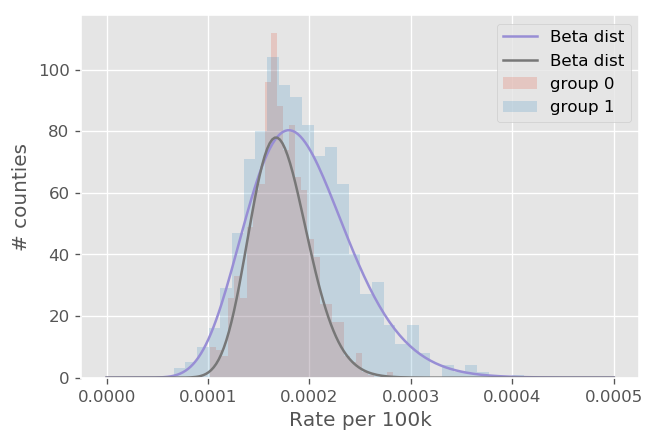

In [24]:
plt.figure(dpi=120)
mask = (incidence['group'] == 0)
X = np.linspace(0, 0.0005, 200)
plt.hist(incidence.loc[mask, 'Rate_per_100k']/1e5, bins=30, label='group 0', alpha=0.2)
plt.hist(incidence.loc[~mask, 'Rate_per_100k']/1e5, bins=30, label='group 1', alpha=0.2)

plt.plot(X, beta.pdf(X, a=gp_param[0][0], b=gp_param[0][1], loc=0, scale=1)/1e2, label='Beta dist')
plt.plot(X, beta.pdf(X, a=gp_param[1][0], b=gp_param[1][1], loc=0, scale=1)/1.8e2, label='Beta dist')

plt.xlabel('Rate per 100k')
plt.ylabel('# counties')
plt.legend()


In [25]:
method_of_moments(incidence['Rate_per_100k']/1e5)

(18.3604767173729, 100862.30552441531)

In [26]:
alpha0, beta0

(19.366567948095202, 106389.18721541032)

In [27]:
method_of_moments(incidence.loc[incidence['group']==0, 'Rate_per_100k']/1e5), method_of_moments(incidence.loc[incidence['group']==1, 'Rate_per_100k']/1e5)

((34.83801543593798, 201934.65048778732),
 (14.134941304716918, 73618.66713803649))

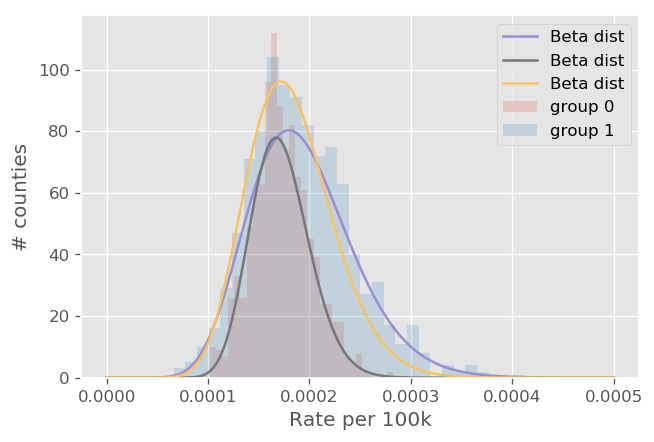

In [28]:
plt.figure(dpi=120)
mask = (incidence['group'] == 0)
X = np.linspace(0, 0.0005, 200)
plt.hist(incidence.loc[mask, 'Rate_per_100k']/1e5, bins=30, label='group 0', alpha=0.2)
plt.hist(incidence.loc[~mask, 'Rate_per_100k']/1e5, bins=30, label='group 1', alpha=0.2)

alpha1, beta1 = method_of_moments(incidence['Rate_per_100k']/1e5)
plt.plot(X, beta.pdf(X, a=gp_param[0][0], b=gp_param[0][1], loc=0, scale=1)/1e2, label='Beta dist')
plt.plot(X, beta.pdf(X, a=gp_param[1][0], b=gp_param[1][1], loc=0, scale=1)/1.8e2, label='Beta dist')
plt.plot(X, beta.pdf(X, a=alpha1, b=beta1, loc=0, scale=1)/1e2, label='Beta dist')

plt.xlabel('Rate per 100k')
plt.ylabel('# counties')
plt.legend()
